In [132]:
import glob, os, re, json, pickle
import pandas as pd
from classifier import *
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tweets import *
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd


In [133]:
df_human = pd.read_json('human_labeled_data.json')
df_human['url'] = df_human['text_data'].str.extract('(https[^\s]*)\s')
df_human['text'] = df_human['text_data'].str.replace('https[^\s]*\s', '')
df_human['manifestolabel_true'] = df_human['major_label'].str.replace('\d\d\d ','')
# df_human['manifestolabel_true'] = df_human['manifestolabel_true'].replace('ignored','undefined')
df_human = df_human.drop(['text_data','labeled','major_label','selected','taught','labels','users','uncertainty','text_id','predicted_label'],axis=1)
df_human.to_json('human_labeled_anonymized.json',orient='records')
df_human

,url,text,manifestolabel_true
0,https://twitter.com/Gert_Woellmann/status/1216...,Weltbeste Bildung! Jetzt! Weltbeste Bildung! J...,education +
1,https://twitter.com/tarogermany1/status/123819...,"(2/2) Das TH in das sie gebracht wurde, ist kn...",environmentalism +
2,https://twitter.com/lcoygermany/status/1259085...,„Heute gekaufte Autos produzieren über 15 Jahr...,environmentalism +
3,https://twitter.com/peppermint_v/status/125562...,Wir brauchen eine Opposition. Das macht eine D...,democracy +
4,https://twitter.com/SPDEuropa/status/121483242...,Rechtsstaat und Demokratie in Europa schützen!...,democracy +
...,...,...,...
1006,https://twitter.com/MSL_Germany/status/1255407...,#MSLInsights-Session zur deutschen EU-Ratspräs...,ignored
1007,https://twitter.com/De_Gedik/status/1223591796...,Der gefährlichste Virus ist Rassismus! Es gibt...,social justice +
1008,https://twitter.com/Klima_Mahner/status/125972...,Windkraft schützt die Umwelt Windkraft schützt...,environmentalism +
1009,https://twitter.com/EichholtzAlex/status/12466...,Reich sind immer die oberen 10 Prozent. Bis ni...,free enterprise +


In [134]:
# read all tweets and remove those that were labeled
df_old_tweets = pd.read_pickle('all_tweets.pickle')#.drop_duplicates('id')
df_old_tweets['text'] = df_old_tweets['text'].fillna('')
df_old_tweets = df_old_tweets[['text','permalink','retweets','favorites','replies','date','manifestolabel_keywords','id']].rename(columns={'permalink':'url','favorites':'likes'})
df_old_tweets

,text,url,retweets,likes,replies,date,manifestolabel_keywords,id
0,Rede über Deine Vision und Ziele! Als viertes ...,https://twitter.com/WISSENAgentur/status/12230...,0.0,0.0,0.0,2020-01-30 23:47:11,internationalism -,1223029926003126273
1,Ruff(us) Brevett Lassie Diarra Graham FENTON F...,https://twitter.com/BarrowsMikeOtto/status/122...,0.0,16.0,3.0,2020-01-30 23:31:26,internationalism -,1223025959869218816
2,Mal ernsthaft diese Tweets in in denen ständig...,https://twitter.com/liam_witte/status/12230248...,0.0,1.0,0.0,2020-01-30 23:27:11,internationalism -,1223024892263784449
3,Ich möchte gerne sie haben recht,https://twitter.com/Sara60603304/status/122302...,0.0,1.0,0.0,2020-01-30 23:16:47,internationalism -,1223022275034742789
4,"Sehr gerne - ich freue mich, wenn es hilft",https://twitter.com/katha_krentz/status/122301...,0.0,1.0,0.0,2020-01-30 22:50:33,internationalism -,1223015670545371136
...,...,...,...,...,...,...,...,...
267769,Das stimmt nur bedingt. Wer sich mit ungarisch...,https://twitter.com/BalazsGabi/status/12453867...,0.0,0.0,0.0,2020-04-01 16:25:04,economic planning +,1.24539e+18
267771,Darum habt ihr das Himmelreich vorgeheuchelt m...,https://twitter.com/Bundesbox/status/124538085...,0.0,0.0,0.0,2020-04-01 16:01:47,economic planning +,1.24538e+18
267787,Du fährst aber auch Programm. Hut ab.,https://twitter.com/LimFoto4u/status/124528015...,0.0,3.0,1.0,2020-04-01 09:21:40,economic planning +,1.24528e+18
267795,Mannheimer Strumpfhersteller Jungfeld hat jetz...,https://twitter.com/tkrooss/status/12452350144...,0.0,0.0,1.0,2020-04-01 06:22:17,economic planning +,1.24524e+18


In [135]:
df = pd.merge(df_human,df_old_tweets,on='url',how='inner')
df['before'] = df['date'] < pd.Timestamp(2020,3,15)
df['after'] = df['date'] > pd.Timestamp(2020,3,15)
df['before'].value_counts()

False    601
True     542
Name: before, dtype: int64

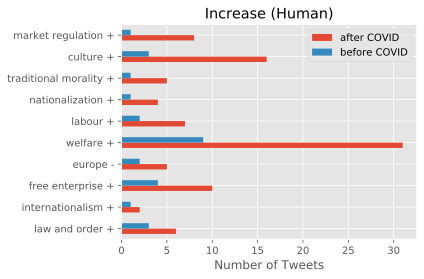

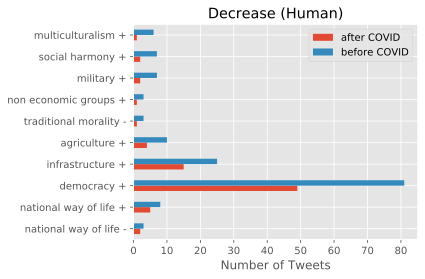

In [130]:
df_human_before_after = pd.DataFrame([df.loc[df['after'],'manifestolabel_true'].value_counts(), df.loc[df['before'],'manifestolabel_true'].value_counts()]).T
df_human_before_after.columns = ['after COVID','before COVID']
df_human_before_after['increase'] = df_human_before_after['after COVID'] / df_human_before_after['before COVID']
df_human_before_after = df_human_before_after[df_human_before_after.index!='ignored']
df_human_before_after = df_human_before_after.dropna(subset=['increase']).sort_values('increase',ascending=False)

(df_human_before_after[['after COVID','before COVID']])[:10][::-1].plot.barh()
plt.xlabel('Number of Tweets')
plt.title('Increase (Human)')
plt.tight_layout()
plt.savefig('increase_human_annotation.pdf')

(df_human_before_after[['after COVID','before COVID']])[-10:].plot.barh()
plt.xlabel('Number of Tweets')
plt.title('Decrease (Human)')
plt.tight_layout()
plt.savefig('decrease_human_annotation.pdf')

In [136]:
df_human_before_after.dropna(subset=['increase'])

,after COVID,before COVID,increase
market regulation +,8.0,1.0,8.000000
culture +,16.0,3.0,5.333333
traditional morality +,5.0,1.0,5.000000
nationalization +,4.0,1.0,4.000000
labour +,7.0,2.0,3.500000
welfare +,31.0,9.0,3.444444
europe -,5.0,2.0,2.500000
free enterprise +,10.0,4.0,2.500000
internationalism +,2.0,1.0,2.000000
law and order +,6.0,3.0,2.000000


In [57]:
dd = score_texts(df_human)
print(classification_report(dd['manifestolabel_true'],dd['manifestolabel']))

                        precision    recall  f1-score   support

                             0.00      0.00      0.00         0
         agriculture +       0.67      0.67      0.67        12
 anti-growth economy +       0.00      0.00      0.00        15
          centralism +       0.00      0.00      0.00         1
        constitution +       0.00      0.00      0.00         1
        constitution -       0.00      0.00      0.00         1
  controlled economy +       0.00      0.00      0.00         1
             culture +       0.62      0.94      0.75        16
        decentralism +       0.00      0.00      0.00         0
           democracy +       0.87      0.70      0.78       108
        economic goals       0.00      0.00      0.00         1
           education +       0.49      0.81      0.61        37
           education -       0.00      0.00      0.00         2
    environmentalism +       0.59      0.88      0.71       144
              europe +       0.74      

/Users/felix/anaconda3/envs/covidstate/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/covidstate/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
df_manifesto = get_manifesto_data()
tweets_train, tweets_test, labels_train,  labels_test = train_test_split(df_human['text'], 
                                                                         df_human['manifestolabel_true'],
                                                                         test_size=.2)
train_text = pd.concat([df_manifesto['text'],tweets_train])
train_labels = pd.concat([df_manifesto['manifestolabel'],labels_train]) 
train_single(train_text, train_labels, 'tweets')

df_test = pd.concat([tweets_test,labels_test],axis=1)
df_test.columns = ['text','manifestolabel_true']
tw = score_texts(df_test,['tweets'])
print(classification_report(tw['manifestolabel_true'],tw['tweets']))

Loading manifesto/manifesto-Germany.csv
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    7.0s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    7.0s finished
/Users/felix/anaconda3/envs/covidstate/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

                             0.00      0.00      0.00         0
         agriculture +       0.75      0.60      0.67         5
 anti-growth economy +       0.00      0.00      0.00         4
          centralism +       0.00      0.00      0.00         1
             culture +       0.43      1.00      0.60         3
           democracy +       1.00      0.65      0.79        23
           education +       0.38      0.30      0.33        10
    environmentalism +       0.80      0.97      0.88        29
              europe +       1.00      1.00      1.00         5
     foreign special +       0.00      0.00      0.00         1
     free enterprise +       0.00      0.00      0.00         2
freedom/human rights +       0.67      0.89      0.76         9
               ignored       0.00      0.00      0.00        30
      infrastructure +       0.50      0.33      0.40         3
    internationalism +       1.00      

/Users/felix/anaconda3/envs/covidstate/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/felix/anaconda3/envs/covidstate/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [112]:
df = pd.read_json('tweets_with_url.json.gzip',compression='gzip')
df['before'] = df['date'] < pd.Timestamp(2020,3,15)
df['after'] = df['date'] > pd.Timestamp(2020,3,15)
df

,text,url,retweets,likes,replies,date,manifestolabel_keywords,id,manifestolabel,tweet_with_url,before,after
41,Das mit China ist doch alles Karma Guck Mal wa...,https://twitter.com/endstoff/status/1222973381...,0,2,0,2020-01-30 20:02:30,internationalism -,1222973381000000000,political authority +,https://twitter.com/endstoff/status/1222973381...,True,False
153,Klima Umweltschutz Rechtsrutsch Korruption Has...,https://twitter.com/the_aeschli/status/1222859...,1,16,1,2020-01-30 12:28:37,internationalism -,1222859159000000000,environmentalism +,https://twitter.com/the_aeschli/status/1222859...,True,False
236,Das Angebot gilt alle Schulen in NRW - gerne b...,https://twitter.com/pacemakerin/status/1222757...,0,2,0,2020-01-30 05:43:15,internationalism -,1222757145000000000,education +,https://twitter.com/pacemakerin/status/1222757...,True,False
301,Großes Interesse und viele Fragen zu #Kaisersl...,https://twitter.com/DFKI/status/12225950274755...,5,8,0,2020-01-29 18:59:03,internationalism -,1222595027000000000,infrastructure +,https://twitter.com/DFKI/status/12225950274755...,True,False
315,Mit dem Haushalt 2020 stärken wir die Bedeutun...,https://twitter.com/HMWK_Hessen/status/1222582...,5,19,0,2020-01-29 18:07:47,internationalism -,1222582126000000000,culture +,https://twitter.com/HMWK_Hessen/status/1222582...,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
850804,@Coenni1 Wie hat Union nochmal gespielt?\n*Hust*,https://twitter.com/Rasselbande74/status/13349...,0,1,1,2020-12-04 21:42:36,europe -,1334976424000000000,political authority +,https://twitter.com/Rasselbande74/status/13349...,False,True
850820,"@ShouraHashemi Ev. peinlich, aber habe heute n...",https://twitter.com/queenofegypt79/status/1334...,0,1,1,2020-12-04 22:03:24,social justice +,1334981659000000000,social justice +,https://twitter.com/queenofegypt79/status/1334...,False,True
850833,@bams_amk Hoe wenn sie die gleiche Luft wie Mä...,https://twitter.com/YourHabibti_/status/133498...,0,1,1,2020-12-04 22:00:17,social justice +,1334980873000000000,social justice +,https://twitter.com/YourHabibti_/status/133498...,False,True
850837,@gerd_dold Im 2. Weltkrieg haben Frauen den He...,https://twitter.com/hannovergenuss/status/1334...,1,4,0,2020-12-04 21:59:46,social justice +,1334980743000000000,social justice +,https://twitter.com/hannovergenuss/status/1334...,False,True


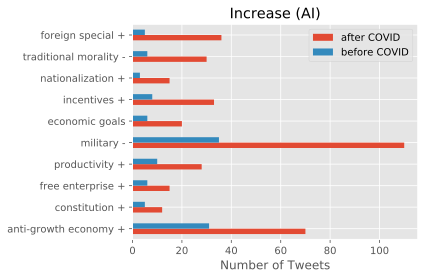

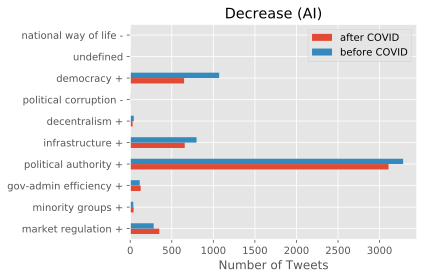

In [118]:

df_ai_before_after = pd.DataFrame([df.loc[df['after'],'manifestolabel'].value_counts(), df.loc[df['before'],'manifestolabel'].value_counts()]).T
df_ai_before_after.columns = ['after COVID','before COVID']
df_ai_before_after['increase'] = df_ai_before_after['after COVID'] / df_ai_before_after['before COVID']
df_ai_before_after = df_ai_before_after[df_ai_before_after.index!='ignored']
df_ai_before_after = df_ai_before_after.dropna(subset=['increase']).sort_values('increase',ascending=False)

(df_ai_before_after[['after COVID','before COVID']])[:10][::-1].plot.barh()
plt.xlabel('Number of Tweets')
plt.title('Increase (AI)')
plt.tight_layout()
plt.savefig('increase_ai_annotation.pdf')

(df_ai_before_after[['after COVID','before COVID']])[-10:].plot.barh()
plt.xlabel('Number of Tweets')
plt.title('Decrease (AI)')
plt.tight_layout()
plt.savefig('decrease_ai_annotation.pdf')